# Survival Time Analysis

This notebook is an exercise to understand STA for event risk analysis and the impact of specific covariate values (e.g. distinct campaigns) on a response variable. The dataset used is sourced from the [UCI Machine Learning Repository](https://web.archive.org/web/20220928135927/http://archive.ics.uci.edu/ml/datasets/Bank+Marketing), and contains information about phone call-based marketing campaigns of a Portuguese banking institution.

Many thanks to [DataTab](https://www.youtube.com/@datatab) and [BioStatSquid](https://www.youtube.com/@biostatsquid) for their lovely YouTube content!

In [ ]:
!curl -L -o datasets/uci-bank-marketing-dataset.zip https://www.kaggle.com/api/v1/datasets/download/janiobachmann/bank-marketing-dataset
!unzip -u datasets/uci-bank-marketing-dataset.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  142k  100  142k    0     0   343k      0 --:--:-- --:--:-- --:--:--  343k
Archive:  datasets/uci-bank-marketing-dataset.zip


In [2]:
from lifelines import CoxPHFitter
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn import preprocessing

## EDA and Preprocessing

### Feature Selection

In [3]:
# Explore predictors
uci_bank_marketing_dataset = pd.read_csv('datasets/bank.csv')
print(uci_bank_marketing_dataset.shape)
uci_bank_marketing_dataset.head()

(11162, 17)


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,673,2,-1,0,unknown,yes


In [ ]:
# Checking for NA values
print(uci_bank_marketing_dataset.isnull().sum())

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
deposit      0
dtype: int64


In [ ]:
# Exploring dtypes
print(uci_bank_marketing_dataset.dtypes)

age           int64
job          object
marital      object
education    object
default      object
balance       int64
housing      object
loan         object
contact      object
day           int64
month        object
duration      int64
campaign      int64
pdays         int64
previous      int64
poutcome     object
deposit      object
dtype: object


In [ ]:
# CHecking for zero-variance, single-valued features that would prevent matrix inversion during fit()
print(uci_bank_marketing_dataset.nunique())

age            76
job            12
marital         3
education       4
default         2
balance      3805
housing         2
loan            2
contact         3
day            31
month          12
duration     1428
campaign       36
pdays         472
previous       34
poutcome        4
deposit         2
dtype: int64


### Minimizing multicollinearity

<Axes: >

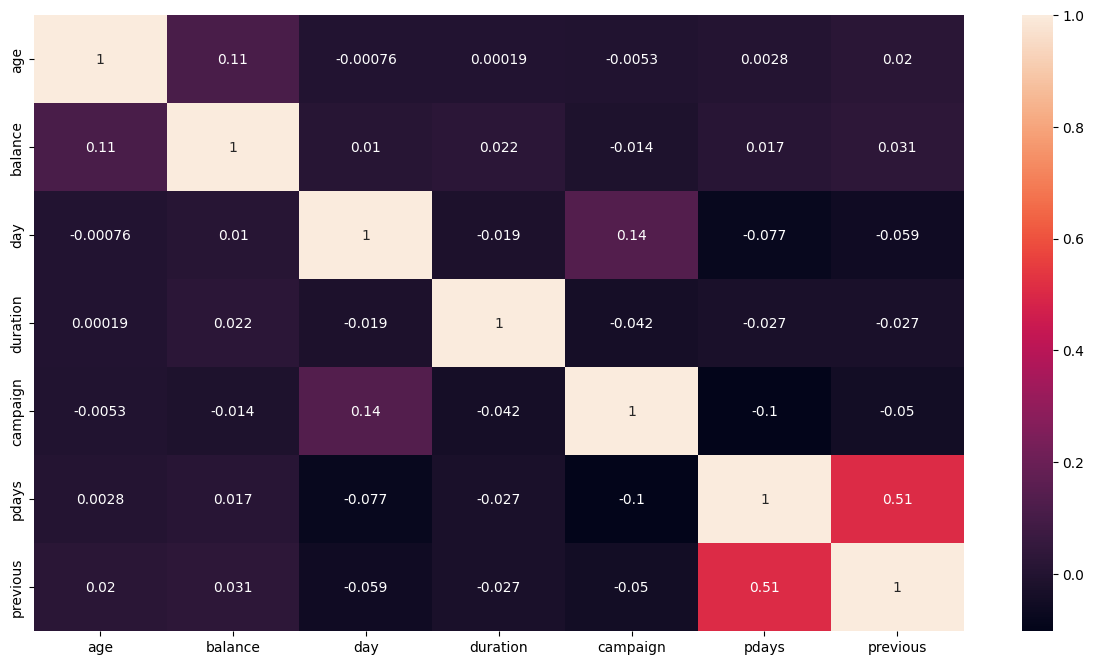

In [6]:
response_variable = 'deposit'
predictor_variables = [predictor for predictor in uci_bank_marketing_dataset.columns if predictor != response_variable]

predictors_df = uci_bank_marketing_dataset[predictor_variables]
response_df = uci_bank_marketing_dataset[response_variable]

# Phase one: numerical predictors only
cm = predictors_df.corr(numeric_only=True)
plt.figure(figsize=(15, 8))
sns.heatmap(cm, xticklabels=cm.columns, yticklabels=cm.columns, annot=True)

In [7]:
# One-hot encoding categoricals for next phase
predictors_df_withcats = pd.get_dummies(predictors_df, dtype=np.float64)

In [46]:
# Variance Inflation Factor (VIF) check for highly multicollinear features
vif_check = pd.DataFrame({
    'VIF': [variance_inflation_factor(predictors_df_withcats.values, i) for i in range(predictors_df_withcats.shape[1])],
    'predictor': predictors_df_withcats.columns,
}).sort_values(by='VIF', ascending=True)
vif_check.head(10)

/Users/avenugopal/Desktop/Prep/Python/jupyter-notebooks/.venv/lib/python3.11/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


,VIF,predictor
3,1.019578,duration
1,1.047247,balance
4,1.110021,campaign
2,1.265290,day
6,1.666208,previous
0,2.104640,age
5,3.516928,pdays
30,inf,loan_no
31,inf,loan_yes
32,inf,contact_cellular


<Axes: >

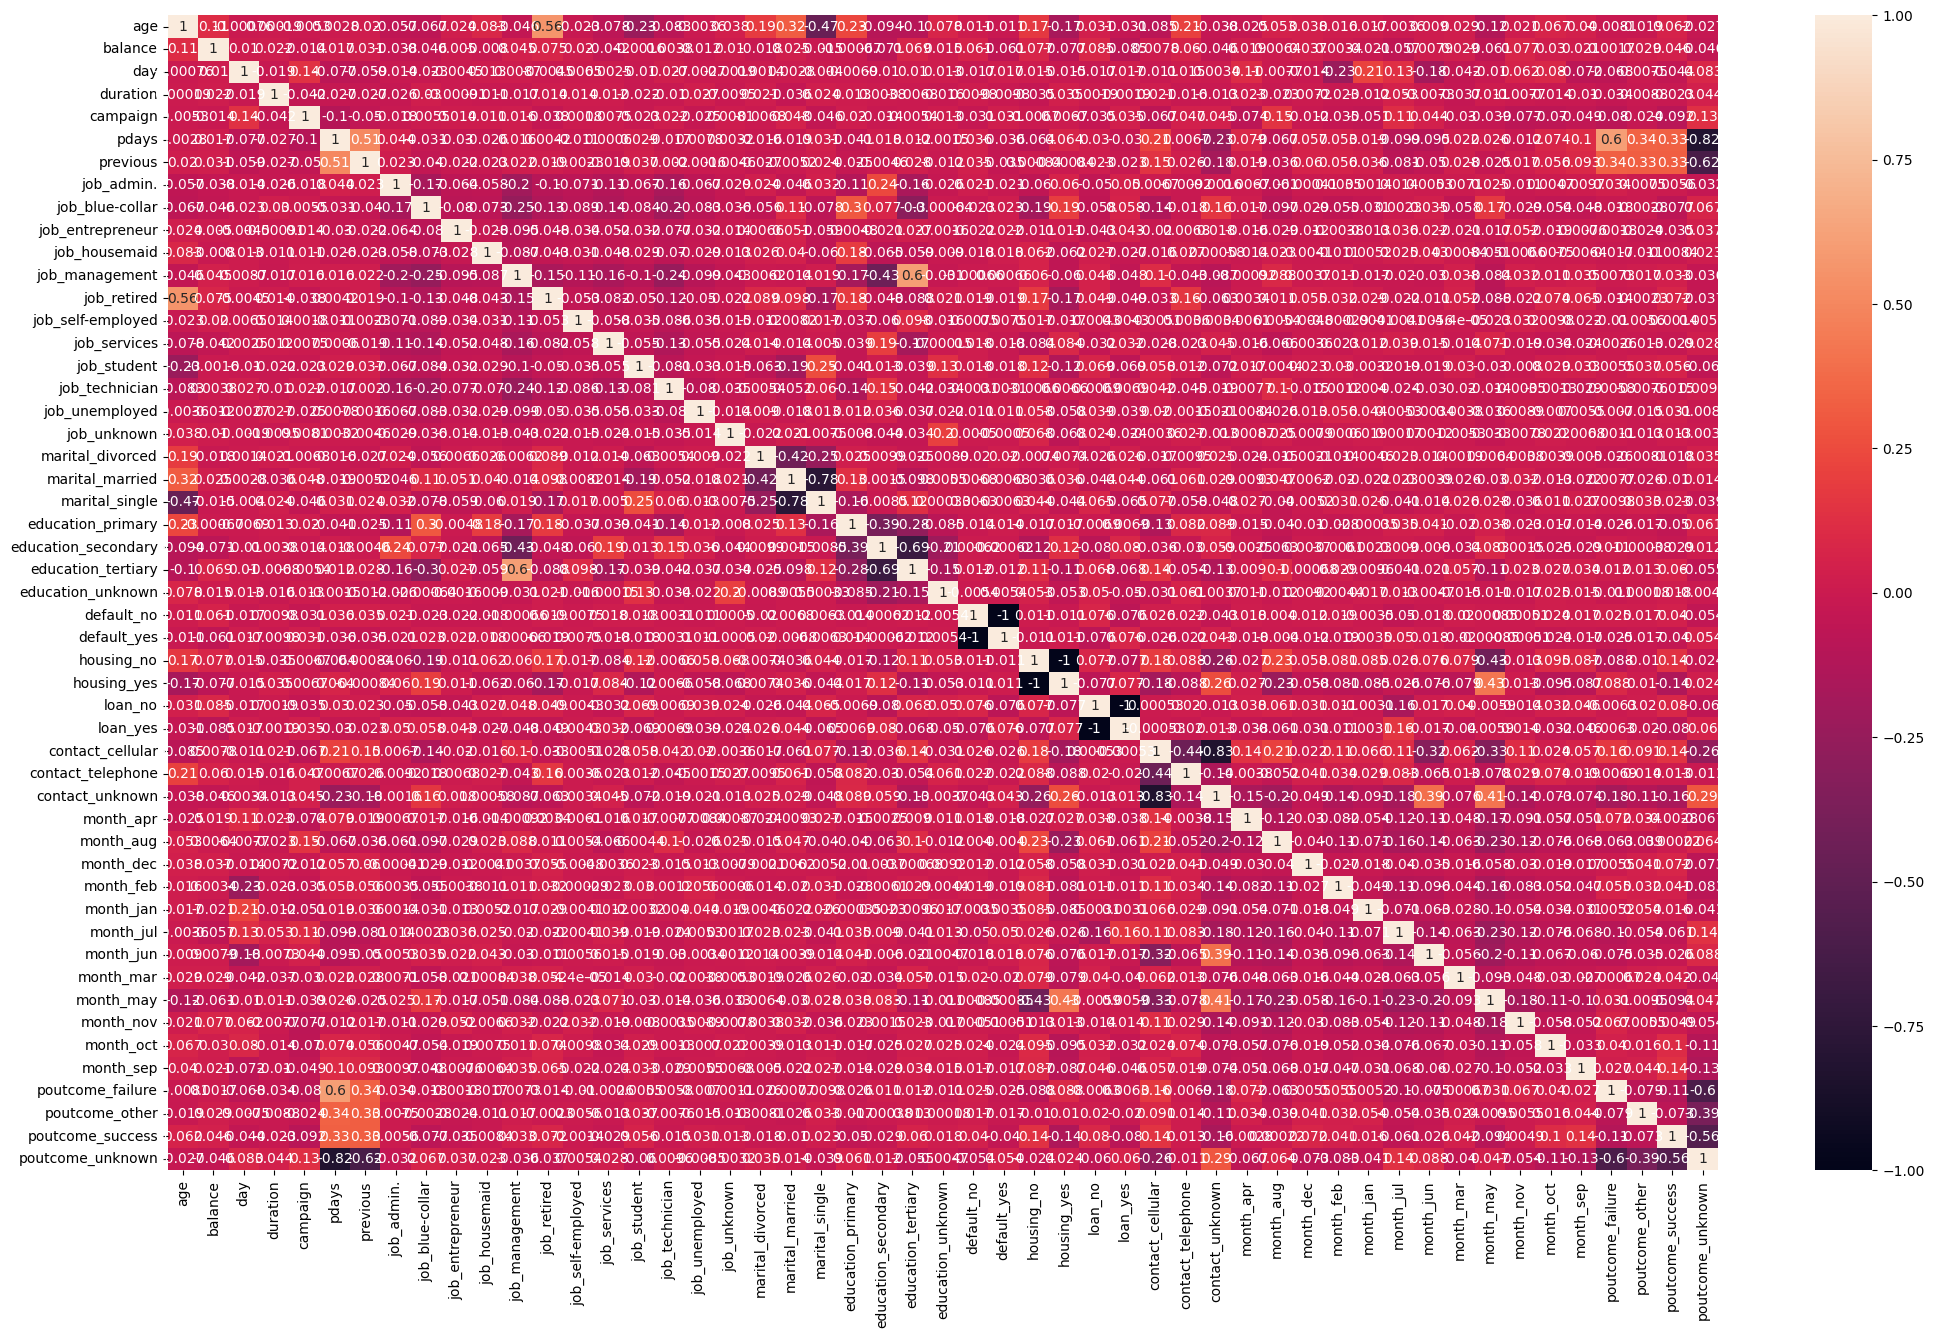

In [ ]:
# Phase two: all predictors, except any that were identified for removal in phase one
cm2 = predictors_df_withcats.corr()
plt.figure(figsize=(25,15))
sns.heatmap(cm2, xticklabels=cm2.columns, yticklabels=cm2.columns, annot=True)

marital_divorced
0.0    9869
1.0    1293
Name: count, dtype: int64


<Axes: >

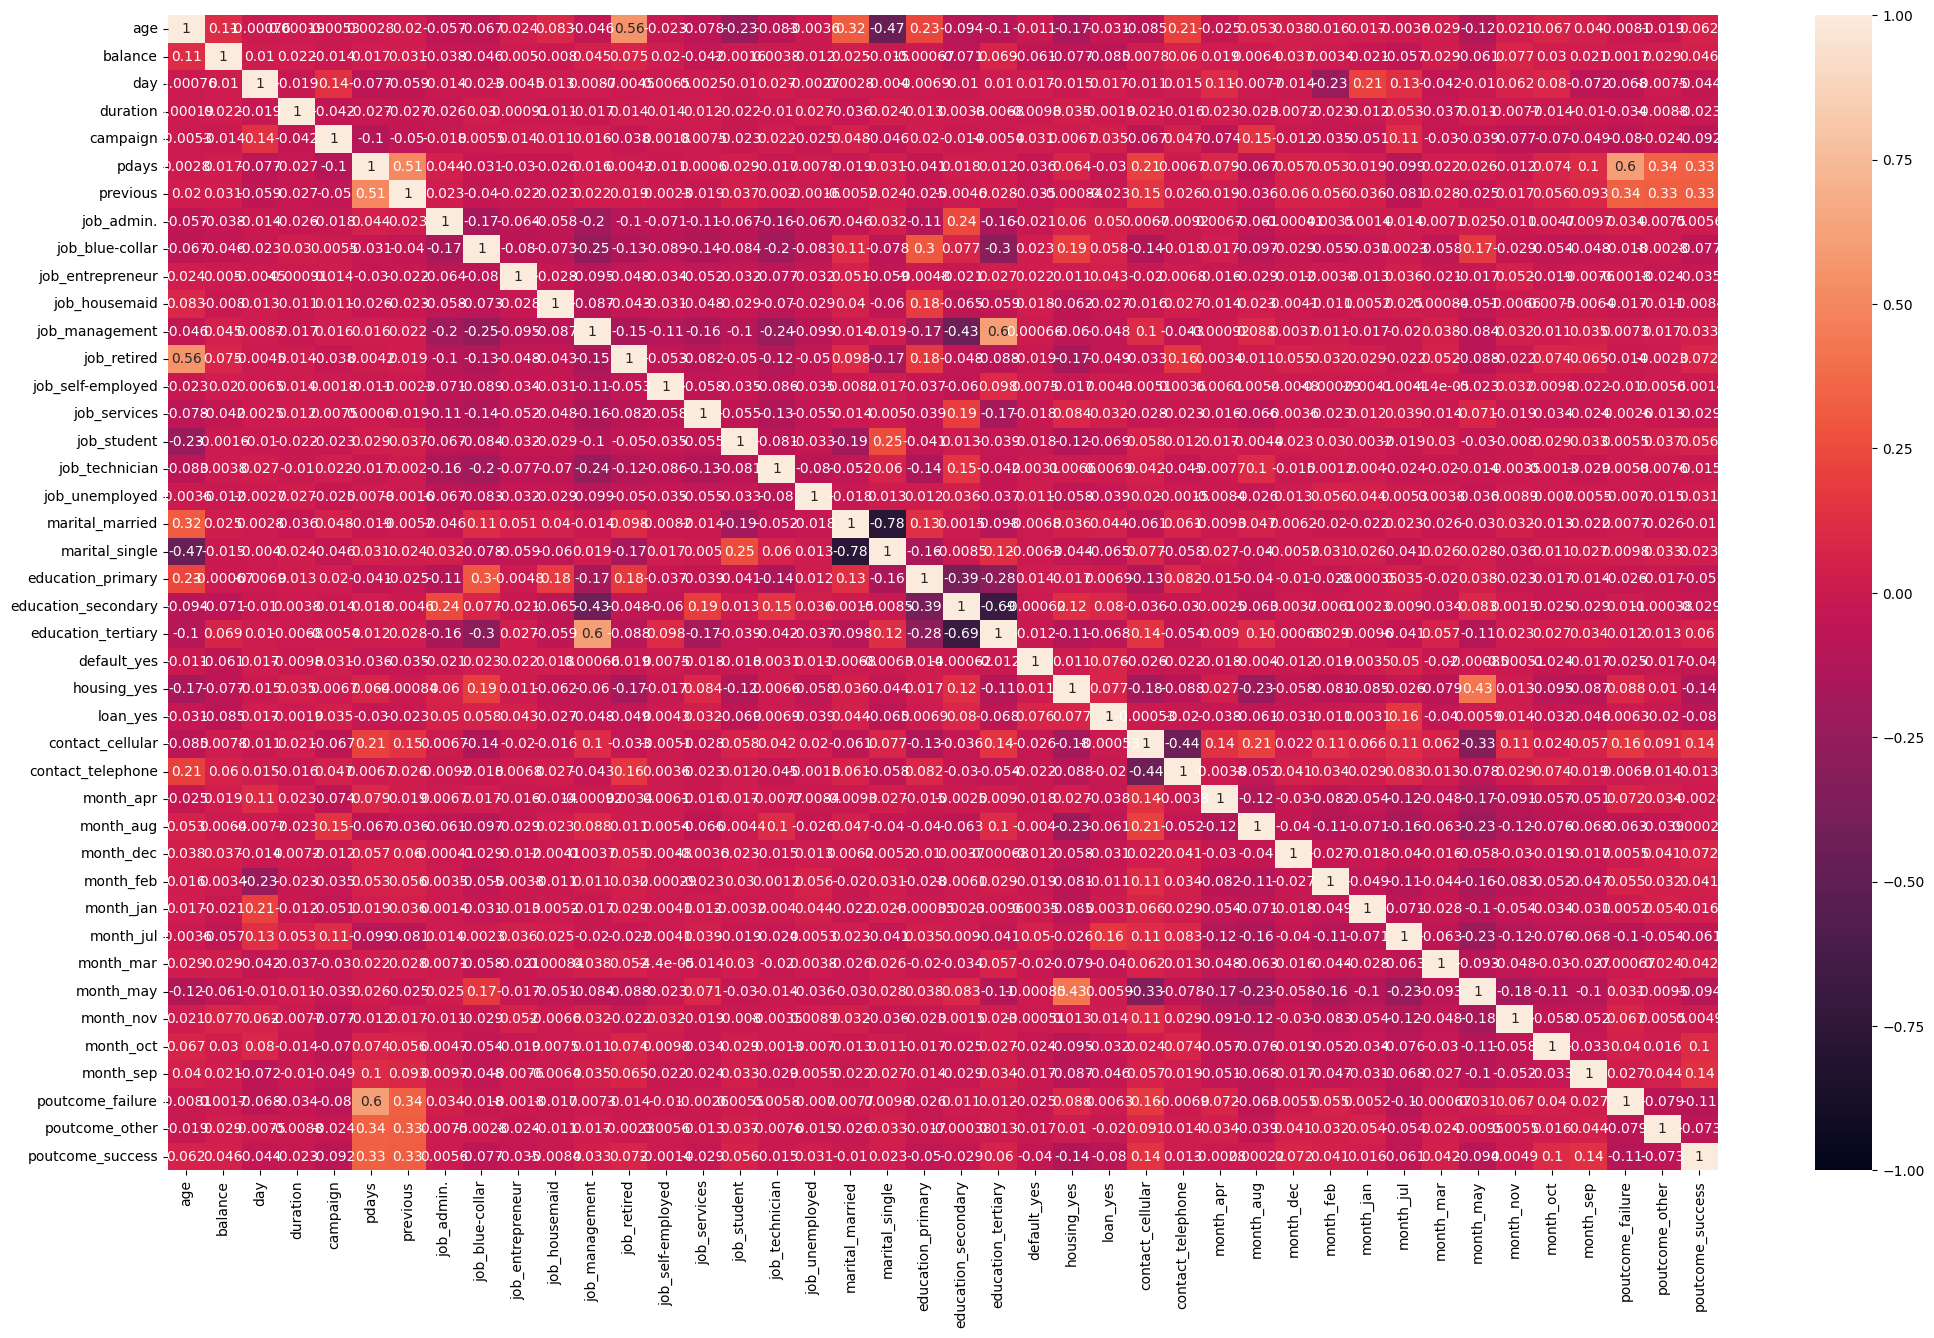

In [ ]:
# Drop predictors based on VIF Check output and heatmap hotspots
print(predictors_df_withcats["marital_divorced"].value_counts())
predictors_df_nocorr = predictors_df_withcats.drop([
    "job_unknown", #  can drop single one-hot column of binary predictor => drop
    "marital_divorced", # Least 1.0s in value_counts => drop
    "education_unknown", #  can drop single one-hot column of binary predictor => drop
    "default_no", # High correlation, can drop single one-hot column of predictor => drop
    "housing_no", # High correlation, can drop single one-hot column of predictor => drop
    "loan_no", # High correlation, can drop single one-hot column of predictor => drop
    "month_jun", # High correlation, can drop single one-hot column of predictor => drop
    "contact_unknown", # High correlation, can drop single one-hot column of predictor => drop
    "poutcome_unknown" # High correlation, can drop single one-hot column of predictor => drop
], axis = 1) 
cm3 = predictors_df_nocorr.corr()
plt.figure(figsize=(25,15))
sns.heatmap(cm3, xticklabels=cm3.columns, yticklabels=cm3.columns, vmin=-1.0, vmax=1.0, annot=True)

In [12]:
# Scale predictors
z_score_norm = preprocessing.StandardScaler()
predictor_df_normalized = z_score_norm.fit_transform(predictors_df_nocorr)
predictor_df_normalized = pd.DataFrame(predictor_df_normalized, columns = predictors_df_nocorr.columns)
predictor_df_normalized

,age,balance,day,duration,campaign,pdays,previous,job_admin.,job_blue-collar,job_entrepreneur,...,month_jan,month_jul,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_other,poutcome_success
0,1.491505,0.252525,-1.265746,1.930226,-0.554168,-0.481184,-0.363260,2.714280,-0.459229,-0.173997,...,-0.178322,-0.396136,-0.159228,1.718298,-0.303775,-0.190781,-0.171522,-0.351590,-0.224814,-0.325782
1,1.239676,-0.459974,-1.265746,3.154612,-0.554168,-0.481184,-0.363260,2.714280,-0.459229,-0.173997,...,-0.178322,-0.396136,-0.159228,1.718298,-0.303775,-0.190781,-0.171522,-0.351590,-0.224814,-0.325782
2,-0.019470,-0.080160,-1.265746,2.929901,-0.554168,-0.481184,-0.363260,-0.368422,-0.459229,-0.173997,...,-0.178322,-0.396136,-0.159228,1.718298,-0.303775,-0.190781,-0.171522,-0.351590,-0.224814,-0.325782
3,1.155733,0.293762,-1.265746,0.596366,-0.554168,-0.481184,-0.363260,-0.368422,-0.459229,-0.173997,...,-0.178322,-0.396136,-0.159228,1.718298,-0.303775,-0.190781,-0.171522,-0.351590,-0.224814,-0.325782
4,1.071790,-0.416876,-1.265746,0.867171,-0.186785,-0.481184,-0.363260,2.714280,-0.459229,-0.173997,...,-0.178322,-0.396136,-0.159228,1.718298,-0.303775,-0.190781,-0.171522,-0.351590,-0.224814,-0.325782
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11157,-0.691015,-0.473616,0.515650,-0.331287,-0.554168,-0.481184,-0.363260,-0.368422,2.177560,-0.173997,...,-0.178322,-0.396136,-0.159228,-0.581971,-0.303775,-0.190781,-0.171522,-0.351590,-0.224814,-0.325782
11158,-0.187357,-0.246658,0.040612,-0.832564,0.547981,-0.481184,-0.363260,-0.368422,-0.459229,-0.173997,...,-0.178322,-0.396136,-0.159228,-0.581971,-0.303775,-0.190781,-0.171522,-0.351590,-0.224814,-0.325782
11159,-0.774958,-0.464934,0.396891,-0.622258,-0.186785,-0.481184,-0.363260,-0.368422,-0.459229,-0.173997,...,-0.178322,-0.396136,-0.159228,-0.581971,-0.303775,-0.190781,-0.171522,-0.351590,-0.224814,-0.325782
11160,0.148416,-0.473926,-0.909466,-1.045752,-0.186785,1.109571,1.818332,-0.368422,-0.459229,-0.173997,...,-0.178322,-0.396136,-0.159228,1.718298,-0.303775,-0.190781,-0.171522,2.844218,-0.224814,-0.325782


## Cox Proportional Hazards model

In [47]:
# Prepare the target dataframe with the reponse
normalized_df = predictor_df_normalized.copy()
normalized_df['deposit'] = response_df.map({'yes': 1, 'no': 0})

### Model Fit

In [38]:
cph = CoxPHFitter()
cph.fit(normalized_df, 'duration', 'deposit')
summary_data = cph.summary[['exp(coef)', 'se(coef)', 'exp(coef) lower 95%', 'exp(coef) upper 95%', 'p','z']]
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 11162 total observations, 5873 right-censored observations>
             duration col = 'duration'
                event col = 'deposit'
      baseline estimation = breslow
   number of observations = 11162
number of events observed = 5289
   partial log-likelihood = -40548.56
         time fit was run = 2025-06-22 23:16:42 UTC

---
                     coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                            
age                 -0.05      0.95      0.02           -0.09           -0.01                0.92                0.99
balance              0.00      1.00      0.01           -0.02            0.02                0.98                1.02
day                  0.01      1.01      0.02           -0.02            0.04                0.98                1.04
campaign            -0.14      0.87      0.02           -0.19           -0.09                0.83                0.91
pdays               -0.03      0.97      0.02           -0.07            0.02                0.93                1.02
previous            -0.01      0.99      0.02           -0.04            0.02                0.96                1.03
job_admin.           0.10      1.10      0.06           -0.02            0.21                0.98                1.24
job_blue-collar      0.03      1.03      0.07           -0.11            0.16                0.90                1.18
job_entrepreneur     0.00      1.00      0.03           -0.06            0.07                0.94                1.07
job_housemaid        0.03      1.03      0.03           -0.03            0.09                0.97                1.10
job_management       0.06      1.06      0.08           -0.09            0.21                0.92                1.24
job_retired          0.07      1.07      0.05           -0.02            0.16                0.98                1.18
job_self-employed    0.01      1.01      0.04           -0.06            0.08                0.94                1.08
job_services         0.02      1.02      0.05           -0.08            0.12                0.92                1.13
job_student          0.09      1.09      0.03            0.02            0.15                1.02                1.17
job_technician       0.07      1.07      0.07           -0.06            0.20                0.94                1.22
job_unemployed      -0.01      0.99      0.03           -0.07            0.06                0.93                1.06
marital_married     -0.01      0.99      0.02           -0.05            0.03                0.95                1.03
marital_single       0.00      1.00      0.02           -0.05            0.05                0.96                1.05
education_primary   -0.09      0.92      0.03           -0.14           -0.03                0.87                0.97
education_secondary -0.09      0.91      0.03           -0.16           -0.03                0.85                0.98
education_tertiary  -0.05      0.95      0.03           -0.12            0.01                0.89                1.01
default_yes          0.01      1.01      0.02           -0.03            0.04                0.97                1.04
housing_yes         -0.17      0.84      0.02           -0.20           -0.14                0.82                0.87
loan_yes            -0.06      0.94      0.02           -0.09           -0.03                0.91                0.97
contact_cellular     0.33      1.38      0.03            0.27            0.38                1.31                1.46
contact_telephone    0.14      1.15      0.02            0.10            0.18                1.11                1.20
month_apr           -0.05      0.95      0.02           -0.09           -0.02                0.91                0.98
month_aug           -0.13      0.88      0.02           -0.18           -0.09            

### Interpreting Results: Forest Plot and Diverging HR Plot

In [58]:
plot_df = summary_data.loc[summary_data['p'] < 0.05]
plot_df.columns = ['HR', 'StdErr', 'CI_L95', 'CI_U95', 'p-value', 'z-value']
plot_df = plot_df.sort_values(by='HR', ascending=False)
plot_df.head()

,HR,StdErr,CI_L95,CI_U95,p-value,z-value
covariate,,,,,,
contact_cellular,1.384258,0.026214,1.314932,1.457238,2.482600e-35,12.404109
poutcome_success,1.249472,0.017845,1.206527,1.293945,9.465134e-36,12.481115
contact_telephone,1.153155,0.020053,1.108711,1.199381,1.193413e-12,7.106131
month_mar,1.102926,0.012792,1.075618,1.130927,1.879221e-14,7.658633
poutcome_failure,1.097087,0.022956,1.048820,1.147575,5.427655e-05,4.036405


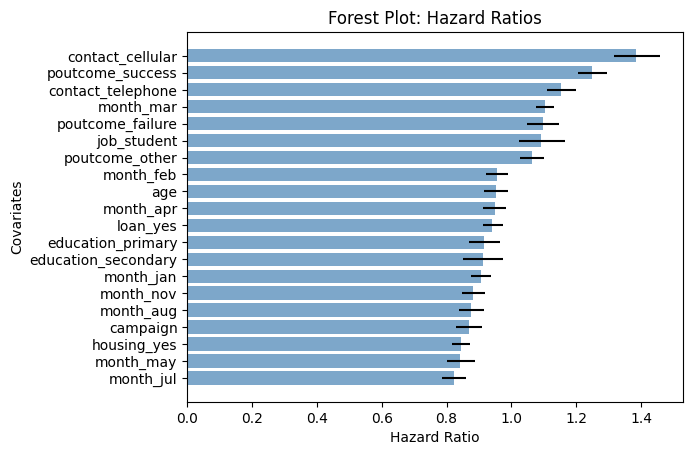

In [141]:
fig, ax = plt.subplots()
plot_df = plot_df.sort_values(by='HR', ascending=True)
ax.barh(
    y=plot_df.index, 
    width=plot_df['HR'], 
    xerr=[
        plot_df['HR'] - plot_df['CI_L95'], 
        plot_df['CI_U95'] - plot_df['HR']
    ], 
    align='center',
    color='steelblue',
    alpha=0.7
)
ax.set_xlabel('Hazard Ratio')
ax.set_ylabel('Covariates')
ax.set_title('Forest Plot: Hazard Ratios')
plt.show()

/var/folders/zg/vq22rp_s67g5bxsmv1x_n_h80000gn/T/ipykernel_29039/2167147846.py:41: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([abs(np.round(tick_value, 2)) for tick_value in ax.get_xticks()])


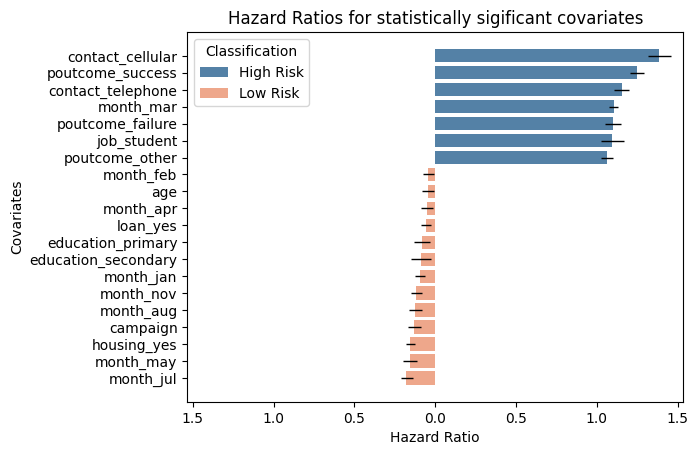

In [157]:
# Diverging Hazard Ratios plot
diverging_plot_df = plot_df.sort_values(by='HR', ascending=False).copy()
diverging_plot_df['HR_centered'] = np.where(diverging_plot_df['HR'] > 1.0, diverging_plot_df['HR'], diverging_plot_df['HR'] - 1.0)
diverging_plot_df['HR_classification'] = np.where(diverging_plot_df['HR'] >= 1.0, 'High Risk', 'Low Risk')
cmap = sns.diverging_palette(h_neg=255, h_pos=0, sep=1, n=len(diverging_plot_df))
ax = sns.barplot(
    data=diverging_plot_df,
    x='HR_centered', 
    y=diverging_plot_df.index, 
    hue='HR_classification', 
    dodge=False,
    palette={'High Risk': '#4682B4', 'Low Risk': '#FFA07A'},
    orient='h'
)



# Equal L/R spacing
max_magnitude = abs(diverging_plot_df['HR_centered'].max() + 0.15)
ax.set_xlim(-max_magnitude, max_magnitude)

for i, (index, row) in enumerate(diverging_plot_df.iterrows()):
    hr = row['HR']
    low = row['CI_L95']
    high = row['CI_U95']
    
    # Centered error range
    left_err = hr - low
    right_err = high - hr
    
    ax.errorbar(
        x=row['HR_centered'],
        y=i,
        xerr=[[left_err], [right_err]],
        fmt='none',
        ecolor='black',
        linewidth=1
    )

# Absolute-valued diverging x-axis ticks
ax.set_xticklabels([abs(np.round(tick_value, 2)) for tick_value in ax.get_xticks()])

ax.set_xlabel('Hazard Ratio')
ax.set_ylabel('Covariates')
ax.set_title('Hazard Ratios for statistically sigificant covariates')
plt.legend(title='Classification')
